In [ ]:
import pandas as pd
import os
from datetime import datetime, timedelta

# Define the path to the data folder
data_folder = os.path.join("Data", "PriceData")

# Function to get the last trading day based on today's date
def get_last_trading_day(reference_date=None):
    """
    Returns the last trading day based on the reference_date.
    If today is Saturday, returns Friday.
    If today is Sunday, returns Friday.
    Otherwise, returns the previous trading day.
    """
    if reference_date is None:
        reference_date = datetime.today()
    else:
        reference_date = reference_date

    # Weekday: Monday=0, Sunday=6
    weekday = reference_date.weekday()

    if weekday == 5:  # Saturday
        last_trading_day = reference_date - timedelta(days=1)
    elif weekday == 6:  # Sunday
        last_trading_day = reference_date - timedelta(days=2)
    else:
        last_trading_day = reference_date

    # Ensure it's a weekday
    if last_trading_day.weekday() >= 5:
        # If it's Saturday or Sunday, adjust to Friday
        last_trading_day -= timedelta(days=last_trading_day.weekday() - 4)
    
    return last_trading_day.date()

# Get the expected latest trading date
expected_latest_date = get_last_trading_day()

# Get list of all .parquet files in the folder
parquet_files = [f for f in os.listdir(data_folder) if f.endswith('.parquet')]

print(f"Found {len(parquet_files)} parquet files in {data_folder}")
print(f"Expected latest trading date: {expected_latest_date}")

# Initialize lists to hold file statuses
stale_files = []
up_to_date_files = []
file_latest_dates = {}

# Iterate over each parquet file
for file in parquet_files:
    file_path = os.path.join(data_folder, file)
    try:
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Check if 'Date' is the index
        if isinstance(df.index, pd.DatetimeIndex):
            latest_date = df.index.max().date()
        elif 'Date' in df.columns:
            # If 'Date' is a column
            df['Date'] = pd.to_datetime(df['Date'])
            latest_date = df['Date'].max().date()
        else:
            print(f"File {file} does not have a 'Date' column or index.")
            continue
        
        # Store the latest date
        file_latest_dates[file] = latest_date
        
        # Compare with expected latest date
        if latest_date < expected_latest_date:
            stale_files.append((file, latest_date))
        else:
            up_to_date_files.append((file, latest_date))
            
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Report Up-to-date Files
print("\n=== Up-to-date Files ===")
for file, date in up_to_date_files:
    print(f"{file}: Latest date = {date}")

# Report Stale Files
print("\n=== Stale Files ===")
for file, date in stale_files:
    print(f"{file}: Latest date = {date}")

# Calculate the percentage of stale files
total_files = len(parquet_files)
stale_count = len(stale_files)
stale_percentage = (stale_count / total_files) * 100 if total_files > 0 else 0

print(f"\nOut of {total_files} files, {stale_count} are out of date.")
print(f"Percentage of stale files: {stale_percentage:.2f}%")


Found 30 parquet files in Data\PriceData
Expected latest trading date: 2024-09-20

=== Up-to-date Files ===
AAPL.parquet: Latest date = 2024-09-20
ABBV.parquet: Latest date = 2024-09-20
AMZN.parquet: Latest date = 2024-09-20
ASML.parquet: Latest date = 2024-09-20
AVGO.parquet: Latest date = 2024-09-20
BAC.parquet: Latest date = 2024-09-20
BRK-B.parquet: Latest date = 2024-09-20
COST.parquet: Latest date = 2024-09-20
GOOGL.parquet: Latest date = 2024-09-20
HD.parquet: Latest date = 2024-09-20
JNJ.parquet: Latest date = 2024-09-20
JPM.parquet: Latest date = 2024-09-20
KO.parquet: Latest date = 2024-09-20
LLY.parquet: Latest date = 2024-09-20
MA.parquet: Latest date = 2024-09-20
META.parquet: Latest date = 2024-09-20
MRK.parquet: Latest date = 2024-09-20
MSFT.parquet: Latest date = 2024-09-20
NFLX.parquet: Latest date = 2024-09-20
NVDA.parquet: Latest date = 2024-09-20
NVO.parquet: Latest date = 2024-09-20
ORCL.parquet: Latest date = 2024-09-20
PG.parquet: Latest date = 2024-09-20
SPY.par

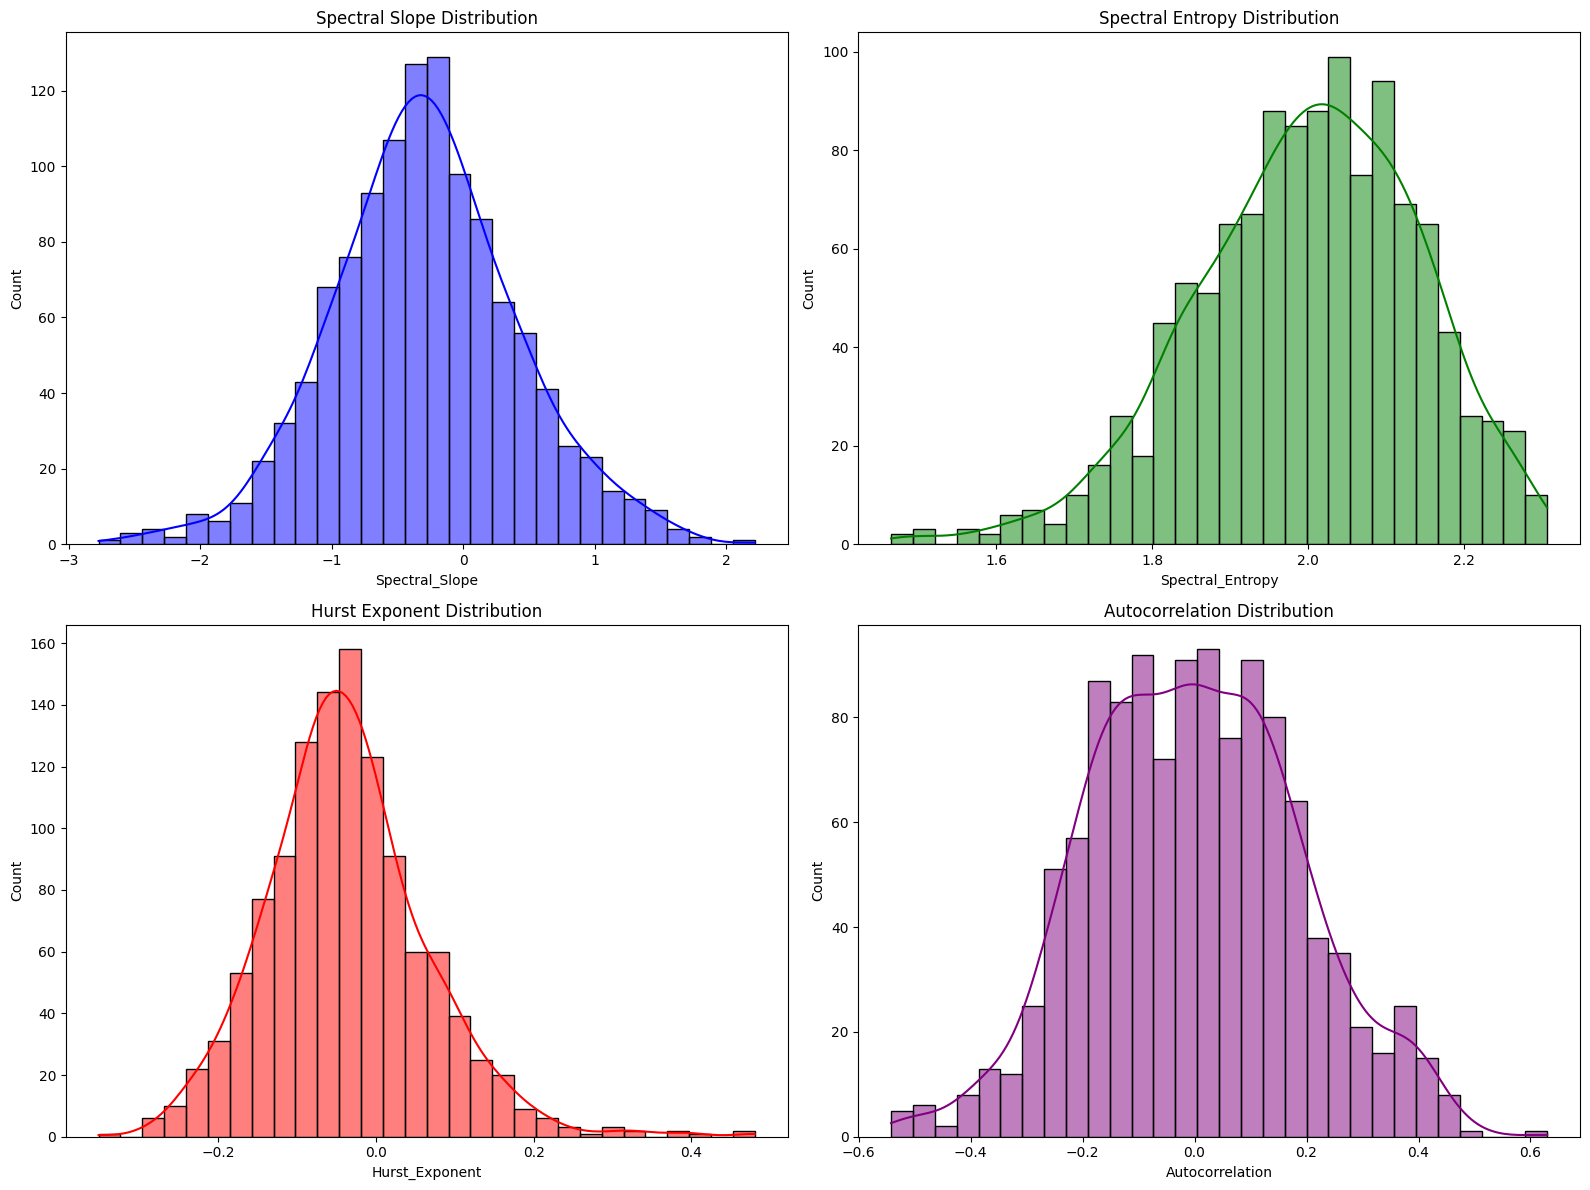

       Spectral_Slope  Spectral_Entropy  Hurst_Exponent  Autocorrelation
count     1168.000000       1168.000000     1168.000000      1168.000000
mean        -0.294380          1.998837       -0.037350        -0.001522
std          0.707980          0.143319        0.102035         0.188879
min         -2.771648          1.464743       -0.351722        -0.542105
25%         -0.737793          1.904536       -0.101524        -0.140351
50%         -0.311306          2.009197       -0.044180        -0.005263
75%          0.135298          2.101642        0.016973         0.124561
max          2.214809          2.307350        0.480545         0.629825


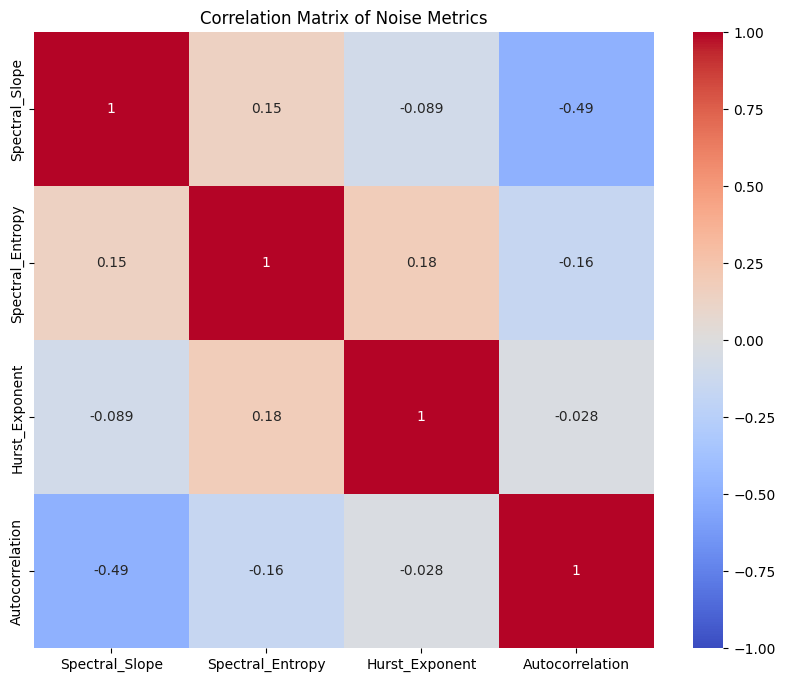

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from scipy.stats import entropy, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Define helper functions for noise calculation
def calculate_spectral_slope(y, fs=1.0):
    freqs, psd = welch(y, fs=fs, nperseg=min(256, len(y)))
    freqs = freqs[1:]
    psd = psd[1:] + 1e-10  # Prevent log(0)
    log_freqs = np.log(freqs)
    log_psd = np.log(psd)
    if len(log_freqs) < 2 or len(log_psd) < 2:
        return np.nan
    slope, _ = np.polyfit(log_freqs, log_psd, 1)
    return slope

def calculate_hurst_exponent(ts):
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags if np.std(ts[lag:] - ts[:-lag]) > 0]
    tau = np.array(tau)
    if len(tau) < 2:
        return np.nan
    return np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)[0] * 2.0

def calculate_spectral_entropy(y, fs=1.0, nperseg=256):
    freqs, psd = welch(y, fs=fs, nperseg=min(nperseg, len(y)))
    psd_norm = psd / np.sum(psd) + 1e-10
    return entropy(psd_norm)

def calculate_autocorrelation(y, lag=1):
    return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan

# Enhanced randomness filter function
def enhanced_randomness_filter(df, window_size=20, data_removal_target=0.10):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    metrics = {'Spectral_Slope': [], 'Spectral_Entropy': [], 'Hurst_Exponent': [], 'Autocorrelation': []}
    
    # Pad the metrics with NaN at the start
    for key in metrics:
        metrics[key] = [np.nan] * (window_size - 1)

    # Iterate over the rolling window to calculate noise metrics
    for i in range(window_size, len(df) + 1):
        window = df['Return'].iloc[i - window_size:i].values
        if np.all(np.isfinite(window)):
            window_norm = MinMaxScaler().fit_transform(window.reshape(-1, 1)).flatten()
            metrics['Spectral_Slope'].append(calculate_spectral_slope(window_norm))
            metrics['Spectral_Entropy'].append(calculate_spectral_entropy(window_norm))
            metrics['Hurst_Exponent'].append(calculate_hurst_exponent(window_norm))
            metrics['Autocorrelation'].append(calculate_autocorrelation(window_norm))
        else:
            for key in metrics:
                metrics[key].append(np.nan)

    # Add the metrics back to the DataFrame
    for key, values in metrics.items():
        df[key] = values

    # Filter the DataFrame based on the calculated metrics
    df_filtered = df.dropna(subset=metrics.keys()).copy()

    return df_filtered, df[metrics.keys()]


# Load Data (replace file paths with your own)
data_dir = 'Data/PriceData'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Load and process one file for exploratory analysis
df = pd.read_parquet(file_paths[0])

# Apply the randomness filter to the data
window_size = 20
data_removal_target = 0.10

filtered_df, noise_metrics_df = enhanced_randomness_filter(df, window_size=window_size, data_removal_target=data_removal_target)

# Plot noise metrics using seaborn
plt.figure(figsize=(16, 12))

# Plot Spectral Slope
plt.subplot(2, 2, 1)
sns.histplot(noise_metrics_df['Spectral_Slope'].dropna(), kde=True, bins=30, color='blue')
plt.title('Spectral Slope Distribution')

# Plot Spectral Entropy
plt.subplot(2, 2, 2)
sns.histplot(noise_metrics_df['Spectral_Entropy'].dropna(), kde=True, bins=30, color='green')
plt.title('Spectral Entropy Distribution')

# Plot Hurst Exponent
plt.subplot(2, 2, 3)
sns.histplot(noise_metrics_df['Hurst_Exponent'].dropna(), kde=True, bins=30, color='red')
plt.title('Hurst Exponent Distribution')

# Plot Autocorrelation
plt.subplot(2, 2, 4)
sns.histplot(noise_metrics_df['Autocorrelation'].dropna(), kde=True, bins=30, color='purple')
plt.title('Autocorrelation Distribution')

plt.tight_layout()
plt.show()

# Summary statistics for noise metrics
print(noise_metrics_df.describe())

# Correlation matrix of noise metrics
plt.figure(figsize=(10, 8))
sns.heatmap(noise_metrics_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Noise Metrics')
plt.show()


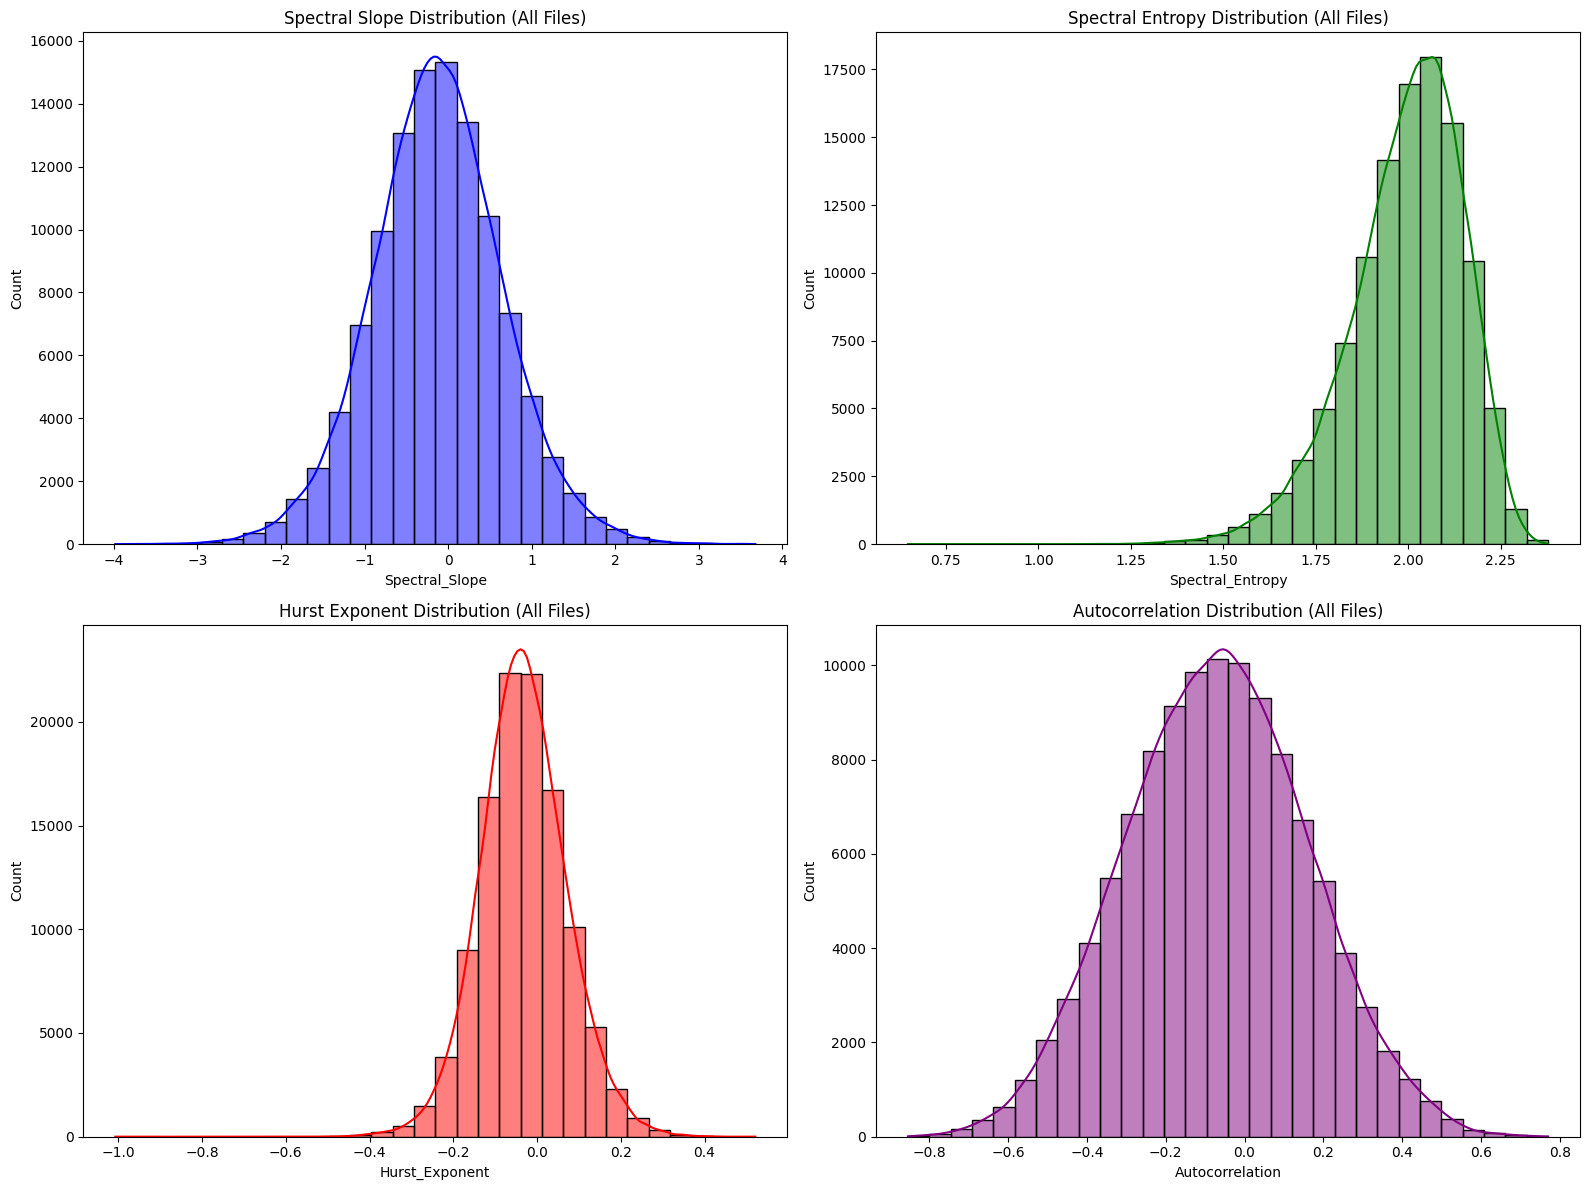

       Spectral_Slope  Spectral_Entropy  Hurst_Exponent  Autocorrelation
count   111850.000000     111850.000000   111850.000000    111850.000000
mean        -0.126592          1.994896       -0.032429        -0.070675
std          0.782156          0.153883        0.103755         0.230997
min         -3.981731          0.647292       -1.007283        -0.854386
25%         -0.628827          1.905123       -0.099345        -0.229825
50%         -0.131072          2.014186       -0.034746        -0.070175
75%          0.371263          2.105180        0.032829         0.087719
max          3.675607          2.378263        0.521339         0.770175


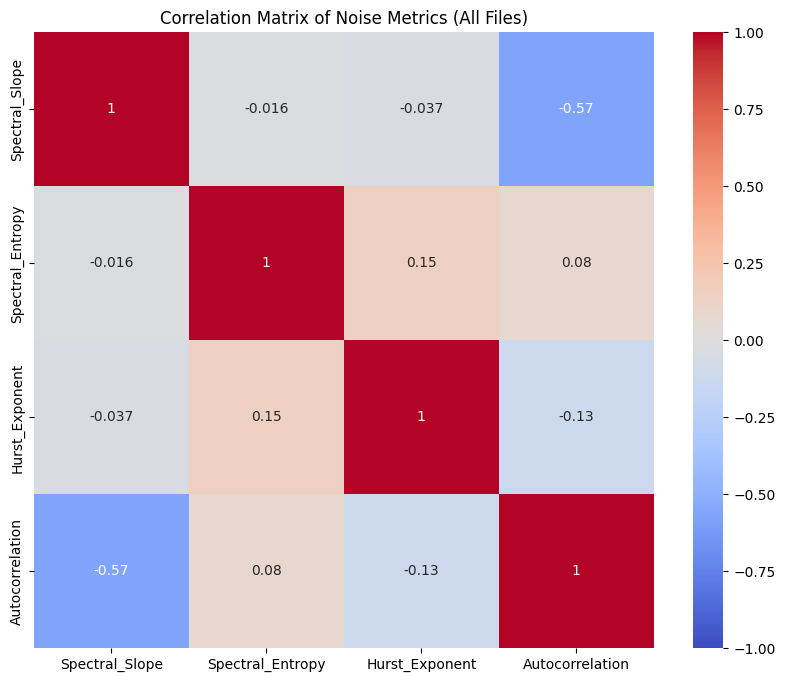

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from scipy.stats import entropy, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Define helper functions for noise calculation
def calculate_spectral_slope(y, fs=1.0):
    freqs, psd = welch(y, fs=fs, nperseg=min(256, len(y)))
    freqs = freqs[1:]
    psd = psd[1:] + 1e-10  # Prevent log(0)
    log_freqs = np.log(freqs)
    log_psd = np.log(psd)
    if len(log_freqs) < 2 or len(log_psd) < 2:
        return np.nan
    slope, _ = np.polyfit(log_freqs, log_psd, 1)
    return slope

def calculate_hurst_exponent(ts):
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags if np.std(ts[lag:] - ts[:-lag]) > 0]
    tau = np.array(tau)
    if len(tau) < 2:
        return np.nan
    return np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)[0] * 2.0

def calculate_spectral_entropy(y, fs=1.0, nperseg=256):
    freqs, psd = welch(y, fs=fs, nperseg=min(nperseg, len(y)))
    psd_norm = psd / np.sum(psd) + 1e-10
    return entropy(psd_norm)

def calculate_autocorrelation(y, lag=1):
    return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan

# Enhanced randomness filter function
def enhanced_randomness_filter(df, window_size=20, data_removal_target=0.10):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    metrics = {'Spectral_Slope': [], 'Spectral_Entropy': [], 'Hurst_Exponent': [], 'Autocorrelation': []}
    
    # Pad the metrics with NaN at the start
    for key in metrics:
        metrics[key] = [np.nan] * (window_size - 1)

    # Iterate over the rolling window to calculate noise metrics
    for i in range(window_size, len(df) + 1):
        window = df['Return'].iloc[i - window_size:i].values
        if np.all(np.isfinite(window)):
            window_norm = MinMaxScaler().fit_transform(window.reshape(-1, 1)).flatten()
            metrics['Spectral_Slope'].append(calculate_spectral_slope(window_norm))
            metrics['Spectral_Entropy'].append(calculate_spectral_entropy(window_norm))
            metrics['Hurst_Exponent'].append(calculate_hurst_exponent(window_norm))
            metrics['Autocorrelation'].append(calculate_autocorrelation(window_norm))
        else:
            for key in metrics:
                metrics[key].append(np.nan)

    # Add the metrics back to the DataFrame
    for key, values in metrics.items():
        df[key] = values

    # Filter the DataFrame based on the calculated metrics
    df_filtered = df.dropna(subset=metrics.keys()).copy()

    return df_filtered, df[metrics.keys()]

# Load all files and process them
data_dir = 'Data/PriceData'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Initialize an empty DataFrame to store noise metrics from all files
all_noise_metrics = pd.DataFrame()

# Loop over all files and apply the randomness filter
# Limit the number of files to process to 20
file_paths_to_process = file_paths[:100]

for file_path in file_paths_to_process:
    df = pd.read_parquet(file_path)

    # Apply the randomness filter to the data
    window_size = 20
    data_removal_target = 0.10

    filtered_df, noise_metrics_df = enhanced_randomness_filter(df, window_size=window_size, data_removal_target=data_removal_target)

    # Append noise metrics to the combined DataFrame
    all_noise_metrics = pd.concat([all_noise_metrics, noise_metrics_df], ignore_index=True)

# Remove any rows with NaN values in the noise metrics (optional)
all_noise_metrics.dropna(inplace=True)

# Plot noise metrics for all files
plt.figure(figsize=(16, 12))

# Plot Spectral Slope
plt.subplot(2, 2, 1)
sns.histplot(all_noise_metrics['Spectral_Slope'].dropna(), kde=True, bins=30, color='blue')
plt.title('Spectral Slope Distribution (All Files)')

# Plot Spectral Entropy
plt.subplot(2, 2, 2)
sns.histplot(all_noise_metrics['Spectral_Entropy'].dropna(), kde=True, bins=30, color='green')
plt.title('Spectral Entropy Distribution (All Files)')

# Plot Hurst Exponent
plt.subplot(2, 2, 3)
sns.histplot(all_noise_metrics['Hurst_Exponent'].dropna(), kde=True, bins=30, color='red')
plt.title('Hurst Exponent Distribution (All Files)')

# Plot Autocorrelation
plt.subplot(2, 2, 4)
sns.histplot(all_noise_metrics['Autocorrelation'].dropna(), kde=True, bins=30, color='purple')
plt.title('Autocorrelation Distribution (All Files)')

plt.tight_layout()
plt.show()

# Summary statistics for noise metrics across all files
print(all_noise_metrics.describe())

# Correlation matrix of noise metrics across all files
plt.figure(figsize=(10, 8))
sns.heatmap(all_noise_metrics.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Noise Metrics (All Files)')
plt.show()


Processing file: Data/PriceData\AAP.parquet
Processing file: Data/PriceData\AAPL.parquet
Processing file: Data/PriceData\AAT.parquet
Processing file: Data/PriceData\AB.parquet
Processing file: Data/PriceData\ABBV.parquet
Processing file: Data/PriceData\ABEV.parquet
Processing file: Data/PriceData\ABG.parquet
Processing file: Data/PriceData\ABM.parquet
Processing file: Data/PriceData\ABR-PD.parquet
Processing file: Data/PriceData\ABR-PE.parquet
Processing file: Data/PriceData\ABR-PF.parquet


C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation 

Processing file: Data/PriceData\ABR.parquet
Processing file: Data/PriceData\ABT.parquet
Processing file: Data/PriceData\AC.parquet
Processing file: Data/PriceData\ACA.parquet
Processing file: Data/PriceData\ACCO.parquet
Processing file: Data/PriceData\ACEL.parquet
Processing file: Data/PriceData\ACHR.parquet
Processing file: Data/PriceData\ACI.parquet
Processing file: Data/PriceData\ACM.parquet
Processing file: Data/PriceData\ACN.parquet
Processing file: Data/PriceData\ACP-PA.parquet
Processing file: Data/PriceData\ACP.parquet
Processing file: Data/PriceData\ACR-PC.parquet
Processing file: Data/PriceData\ACR-PD.parquet


C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation 

Processing file: Data/PriceData\ACR.parquet
Processing file: Data/PriceData\ACRE.parquet
Processing file: Data/PriceData\ACU.parquet
Processing file: Data/PriceData\ACV.parquet
Processing file: Data/PriceData\ADC-PA.parquet
Processing file: Data/PriceData\ADC.parquet
Processing file: Data/PriceData\ADCT.parquet
Processing file: Data/PriceData\ADM.parquet
Processing file: Data/PriceData\ADNT.parquet
Processing file: Data/PriceData\ADRT.parquet
Processing file: Data/PriceData\ADT.parquet
Processing file: Data/PriceData\ADX.parquet
Processing file: Data/PriceData\AE.parquet
Processing file: Data/PriceData\AEE.parquet
Processing file: Data/PriceData\AEF.parquet
Processing file: Data/PriceData\AEFC.parquet
Processing file: Data/PriceData\AEG.parquet
Processing file: Data/PriceData\AEM.parquet
Processing file: Data/PriceData\AEO.parquet
Processing file: Data/PriceData\AER.parquet
Processing file: Data/PriceData\AES.parquet
Processing file: Data/PriceData\AESI.parquet
Processing file: Data/Pr

C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:34: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / np.sum(psd) + 1e-10
C:\Users\Masam\AppData\Local\Temp\ipykernel_7716\660947276.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y[:-lag], y[lag:]).correlation 

Processing file: Data/PriceData\AFB.parquet
Processing file: Data/PriceData\AFG.parquet
Processing file: Data/PriceData\AFGB.parquet
Processing file: Data/PriceData\AFGC.parquet
Processing file: Data/PriceData\AFGD.parquet
Processing file: Data/PriceData\AFGE.parquet
Processing file: Data/PriceData\AFL.parquet
Processing file: Data/PriceData\AG.parquet
Processing file: Data/PriceData\AGCO.parquet
Processing file: Data/PriceData\AGD.parquet
Processing file: Data/PriceData\AGI.parquet
Processing file: Data/PriceData\AGL.parquet
Processing file: Data/PriceData\AGM-A.parquet
Processing file: Data/PriceData\AGM-PD.parquet
Processing file: Data/PriceData\AGM-PE.parquet
Processing file: Data/PriceData\AGM-PF.parquet
Processing file: Data/PriceData\AGM-PG.parquet
Processing file: Data/PriceData\AGM.parquet
Processing file: Data/PriceData\AGO.parquet
Processing file: Data/PriceData\AGQ.parquet
Processing file: Data/PriceData\AGR.parquet
Processing file: Data/PriceData\AGRO.parquet
Processing fi

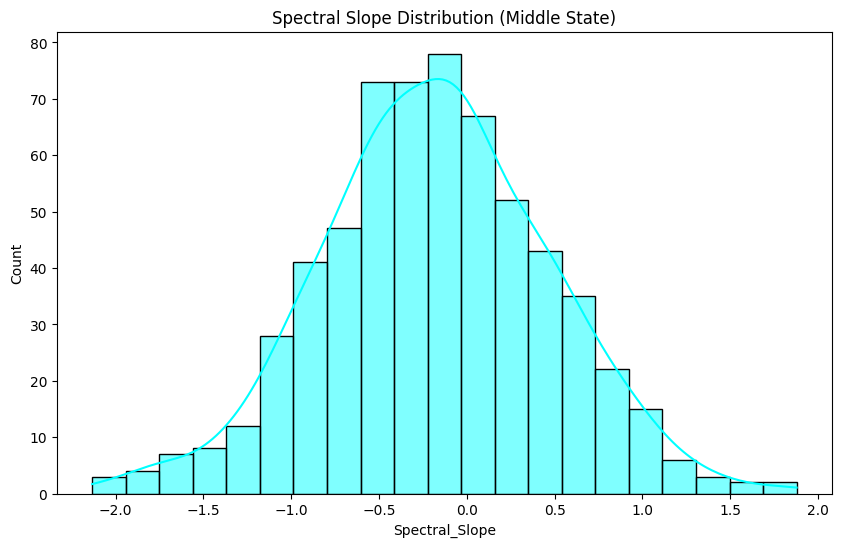

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from scipy.stats import entropy, spearmanr

# Reuse the same helper functions for noise metrics (as in your existing code)



# Define helper functions for noise calculation
def calculate_spectral_slope(y, fs=1.0):
    freqs, psd = welch(y, fs=fs, nperseg=min(256, len(y)))
    freqs = freqs[1:]
    psd = psd[1:] + 1e-10  # Prevent log(0)
    log_freqs = np.log(freqs)
    log_psd = np.log(psd)
    if len(log_freqs) < 2 or len(log_psd) < 2:
        return np.nan
    slope, _ = np.polyfit(log_freqs, log_psd, 1)
    return slope

def calculate_hurst_exponent(ts):
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags if np.std(ts[lag:] - ts[:-lag]) > 0]
    tau = np.array(tau)
    if len(tau) < 2:
        return np.nan
    return np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)[0] * 2.0

def calculate_spectral_entropy(y, fs=1.0, nperseg=256):
    freqs, psd = welch(y, fs=fs, nperseg=min(nperseg, len(y)))
    psd_norm = psd / np.sum(psd) + 1e-10
    return entropy(psd_norm)

def calculate_autocorrelation(y, lag=1):
    return spearmanr(y[:-lag], y[lag:]).correlation if len(y) > lag else np.nan

# Enhanced randomness filter function with middle state identification
def enhanced_randomness_filter(df, window_size=20):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().replace([np.inf, -np.inf], np.nan).dropna()

    metrics = {'Spectral_Slope': [], 'Spectral_Entropy': [], 'Hurst_Exponent': [], 'Autocorrelation': []}
    
    # Pad the metrics with NaN at the start
    for key in metrics:
        metrics[key] = [np.nan] * (window_size - 1)

    # Iterate over the rolling window to calculate noise metrics
    for i in range(window_size, len(df) + 1):
        window = df['Return'].iloc[i - window_size:i].values
        if np.all(np.isfinite(window)):
            window_norm = MinMaxScaler().fit_transform(window.reshape(-1, 1)).flatten()
            metrics['Spectral_Slope'].append(calculate_spectral_slope(window_norm))
            metrics['Spectral_Entropy'].append(calculate_spectral_entropy(window_norm))
            metrics['Hurst_Exponent'].append(calculate_hurst_exponent(window_norm))
            metrics['Autocorrelation'].append(calculate_autocorrelation(window_norm))
        else:
            for key in metrics:
                metrics[key].append(np.nan)

    # Add the metrics back to the DataFrame
    for key, values in metrics.items():
        df[key] = values

    # Drop rows with NaN values in the noise metrics
    df_filtered = df.dropna(subset=metrics.keys()).copy()
    
    # Calculate percentiles to define boundaries for random and orderly data
    def calculate_percentile_bounds(df_filtered, metric, lower_percentile=10, upper_percentile=90):
        lower_bound = np.percentile(df_filtered[metric].dropna(), lower_percentile)
        upper_bound = np.percentile(df_filtered[metric].dropna(), upper_percentile)
        return lower_bound, upper_bound
    
    # Apply the randomness and orderliness thresholds for all noise metrics
    boundaries = {}
    for metric in metrics.keys():
        boundaries[metric] = calculate_percentile_bounds(df_filtered, metric)

    # Flag the top 10% most random and the bottom 10% most orderly
    df_filtered['Randomness_Flag'] = 0  # Initialize a flag column

    # Flag highly random data (upper bound in entropy and low bound in autocorrelation & hurst exponent)
    for metric in ['Spectral_Entropy', 'Hurst_Exponent', 'Autocorrelation']:
        lower_bound, upper_bound = boundaries[metric]
        # For randomness: High entropy, Low Hurst, Low Autocorrelation
        if metric == 'Spectral_Entropy':
            df_filtered.loc[df_filtered[metric] >= upper_bound, 'Randomness_Flag'] = 1  # Random data
        else:
            df_filtered.loc[df_filtered[metric] <= lower_bound, 'Randomness_Flag'] = 1  # Random data

    # Flag highly orderly data (low entropy, high Hurst exponent, and high autocorrelation)
    for metric in ['Spectral_Entropy', 'Hurst_Exponent', 'Autocorrelation']:
        lower_bound, upper_bound = boundaries[metric]
        # For orderliness: Low entropy, High Hurst, High Autocorrelation
        if metric == 'Spectral_Entropy':
            df_filtered.loc[df_filtered[metric] <= lower_bound, 'Randomness_Flag'] = -1  # Orderly data
        else:
            df_filtered.loc[df_filtered[metric] >= upper_bound, 'Randomness_Flag'] = -1  # Orderly data

    # The middle state is where Randomness_Flag == 0
    df_middle_state = df_filtered[df_filtered['Randomness_Flag'] == 0]

    return df_filtered, df_middle_state

# Loading and processing multiple files
data_dir = 'Data/PriceData'
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Initialize an empty DataFrame to store noise metrics from all files
all_noise_metrics = pd.DataFrame()

# Loop over all files and apply the randomness filter
file_paths_to_process = file_paths[:100]

for file_path in file_paths_to_process:
    print(f"Processing file: {file_path}")
    df = pd.read_parquet(file_path)

    # Apply the randomness filter to the data
    window_size = 20

    filtered_df, middle_state_df = enhanced_randomness_filter(df, window_size=window_size)

    # Append noise metrics to the combined DataFrame
    all_noise_metrics = pd.concat([all_noise_metrics, filtered_df], ignore_index=True)

# Summary statistics for noise metrics across all files
print(all_noise_metrics.describe())

# Distribution of middle-state data
print("Middle State Data Count:", middle_state_df.shape[0])

# Visualize the flagged data (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(middle_state_df['Spectral_Slope'].dropna(), kde=True, color='cyan')
plt.title('Spectral Slope Distribution (Middle State)')
plt.show()


In [1]:
import pandas as pd

# Load the parquet file
file = "_Buy_Signals.parquet"
df = pd.read_parquet(file)

# Create an empty DataFrame with the same columns
empty_df = pd.DataFrame(columns=df.columns)

# Print the empty DataFrame to verify
print(empty_df)
##save the empty dataframe to a new parquet file
empty_df.to_parquet("_Buy_Signals.parquet")

Empty DataFrame
Columns: [Symbol, LastBuySignalDate, LastBuySignalPrice, IsCurrentlyBought, ConsecutiveLosses, LastTradedDate, UpProbability, LastSellPrice, PositionSize]
Index: []


In [2]:
import pandas as pd

# Load the parquet file
file = "_Buy_Signals.parquet"
df = pd.read_parquet(file)

print(df.tail())

Empty DataFrame
Columns: [Symbol, LastBuySignalDate, LastBuySignalPrice, IsCurrentlyBought, ConsecutiveLosses, LastTradedDate, UpProbability, LastSellPrice, PositionSize]
Index: []


Processing files: 100%|██████████| 2833/2833 [00:03<00:00, 793.52file/s]

Anomalous Files Detected:


,Start Date,End Date
ABR-PD.parquet,2022-03-11,2024-09-27
ABR-PE.parquet,2022-05-20,2024-09-27
ABR-PF.parquet,2022-07-22,2024-09-27
ACHR.parquet,2021-10-06,2024-09-27
ACI.parquet,2021-04-14,2024-09-27
...,...,...
ZGN.parquet,2022-10-06,2024-09-27
ZH.parquet,2022-01-10,2024-09-27
ZIM.parquet,2021-11-11,2024-09-27
ZIP.parquet,2022-03-11,2024-09-27


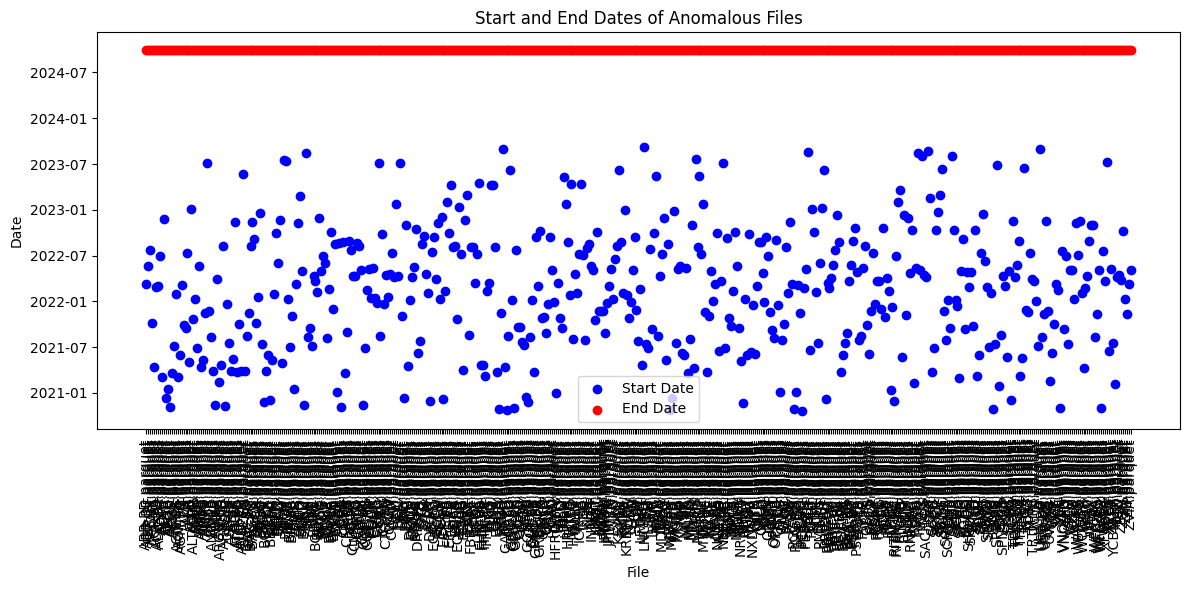

In [14]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder path for the data files
folder_path = "Data/RFpredictions"

# Initialize a list to hold the date ranges of each file
date_ranges = {}

# Define the latest date to check for consistency
latest_date = pd.Timestamp("2024-09-27")

# Load all Parquet files and check their date ranges
files = [f for f in os.listdir(folder_path) if f.endswith(".parquet")]
total_files = len(files)

# Progress bar setup with tqdm
with tqdm(total=total_files, desc="Processing files", unit="file") as pbar:
    for file in files:
        # Read the Parquet file
        file_path = os.path.join(folder_path, file)
        df = pd.read_parquet(file_path)
        
        # Check the date range
        start_date = df["Date"].min()
        end_date = df["Date"].max()
        
        # Store the date range
        date_ranges[file] = (start_date, end_date)
        
        # Update the progress bar
        pbar.update(1)

# Convert date_ranges to a DataFrame for easier analysis
date_ranges_df = pd.DataFrame(date_ranges, index=["Start Date", "End Date"]).T

# Detect the common start and end dates across most files
most_common_start = date_ranges_df["Start Date"].mode()[0]
most_common_end = date_ranges_df["End Date"].mode()[0]

# Identify anomalous files
anomalous_files = date_ranges_df[
    (date_ranges_df["Start Date"] != most_common_start) | 
    (date_ranges_df["End Date"] != most_common_end)
]

# Display only the anomalous files
if not anomalous_files.empty:
    print("Anomalous Files Detected:")
    display(anomalous_files)
    
    # Plot the start and end dates of the anomalous files
    plt.figure(figsize=(12, 6))
    
    # Plot start dates
    plt.scatter(anomalous_files.index, anomalous_files['Start Date'], color='blue', label='Start Date')
    
    # Plot end dates
    plt.scatter(anomalous_files.index, anomalous_files['End Date'], color='red', label='End Date')
    
    # Formatting the plot
    plt.xlabel('File')
    plt.ylabel('Date')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('Start and End Dates of Anomalous Files')
    
    # Show plot
    plt.tight_layout()
    plt.show()

else:
    print("No anomalies found. All files have consistent date ranges.")
